In [23]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as ndi 
from importlib import reload
import pickle
import czifile
%matplotlib inline

# Import my packages.
import sys
sys.path.append('/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin')
import imagep as imp
reload(imp)
from imagep import viewer, save_pickle, load_pickle, box_spots, read_czi

In [3]:
eve_mvs = [
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20180811-rpb1-eve-em1-zsmv-03.pkl',
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20180811-rpb1-eve-em1-zsmv-06.pkl',
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20180811-rpb1-eve-em2-zsmv-04-05.pkl',
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20180915-rpb1-eve-em4-zsmv-01-02.pkl',
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20180915-rpb1-eve-em4-zsmv-04-06.pkl',
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20180915-rpb1-eve-em4-zsmv-07.pkl',
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20180915-rpb1-eve-em5-zsmv-02-03.pkl',
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20180915-rpb1-eve-em5-zsmv-05-04.pkl',
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20180915-rpb1-eve-em6-zsmv-02.pkl'  
]

In [4]:
# Combine all traces.
def combine_intvols(mvs):
    def concat_dfs(a, b):
        def pad_df(small, big):
            pad = np.empty((len(big) - len(small), small.shape[1]))
            pad[:] = np.nan
            padded = np.concatenate([pad, small], axis=0)
            return padded
    
        if (len(a) < len(b)):
            a = pad_df(a, b)
        elif (len(b) < len(a)):
            b = pad_df(b, a)
    
        return np.concatenate([a,b], axis=1)
    
    mv = load_pickle(mvs[0])
    intvol = np.array(mv.intvol.copy())
    prot = np.array(mv.prot.copy())
    
    del mv
    for file in mvs[1:]:
        mv = load_pickle(file)
        intvol = concat_dfs(intvol, mv.intvol)
        prot = concat_dfs(prot, mv.prot)
        del mv

    return pd.DataFrame(intvol), pd.DataFrame(prot)

intvol, prot = combine_intvols(eve_mvs)

In [5]:
def filter_df_minlen(df, minlen):
    df_f = df.copy()
    def test(x):
        if (np.count_nonzero(~np.isnan(x)) >= minlen):
            return True
        return False
    boolean = df_f.apply(test, axis=0)
    df_f = df_f.iloc[:,np.where(boolean)[0]]
    df_f.columns=np.arange(1, df_f.shape[1]+1)
    return df_f

In [6]:
intvol_f = filter_df_minlen(intvol, 25)
prot_f = filter_df_minlen(prot, 25)

In [7]:
def interp_nan(x):
        """Replace internal NAs with values interpolated as the means of the 
        nearest non-NA values"""
        indexes_nan = np.where(np.isnan(x))[0]
        for i in indexes_nan:
            prev_valid = find_nearest_nonnan(x, i, -1)
            next_valid = find_nearest_nonnan(x, i, 1)
            x.iloc[i] = np.mean([prev_valid, next_valid])
        return x
    
def findrises(df, windowsize, lag, min_, max_, rise=True, norm=True, display=False):
    events = []
    for spot in df:
        data = df[spot].copy()
        if (norm):
            data_norm = (data - data.min()) / (data.max() - data.min())
        else:
            data_norm = data
        rolling_avg = data_norm.rolling(windowsize, center=True).mean()
        diff = rolling_avg.diff(lag)
        
        if rise:
            indices = np.where((diff > min_) & (diff < max_))
        else:
            indices = np.where((diff < (-1 * min_)) & (diff > (-1 * max_)))
        
        """
        last_index = [0,0]
        for i in indices[0]:
            # In a run of consecutive indexes.
            if (last_index == [spot, i-1]):
                last_index = [spot, i]
            else:
                events.append([spot, i])
                last_index = [spot, i]
        """
        for i in indices[0]:
            events.append([spot, i])
            
    if display:
        nframes = len(df)
        ax = imp.qax(nframes+1)

        for n in range(1, nframes-1):
            ax[n].plot(df[n])
            for event in events:
                if (event[0] == n):
                    pass
                    ax[n].axvline([event[1]], color="black", linestyle="--")
    print(len(events))
    return events

def plot_triggered(df1, df2, locs, norm=True):
    def norm_(x):
        return (x - x.min()) / (x.max() - x.min()) 
    df1_means = imp.align_traces(df1, locs, 25).mean()
    df2_means = imp.align_traces(df2, locs, 25).mean()
    
    if (norm):
        df1_means = norm_(df1_means);
        df2_means = norm_(df2_means);
    df1_means_smooth = df1_means.rolling(3).mean()
    df2_means_smooth = df2_means.rolling(3).mean()
    #df1_means_smooth.plot(linewidth=3, marker="o")
    xvals = np.arange(-12, 13) * 18
    plt.plot(xvals, df1_means_smooth, linewidth=5, marker="o", markersize=10)
    plt.plot(xvals, df2_means_smooth, linewidth=5, marker="o", markersize=10)
    majorticks = np.arange(-180, 181, 60)
    plt.xticks(majorticks)
    plt.axvline([0], color="black", linestyle="--");




2868
1166
249


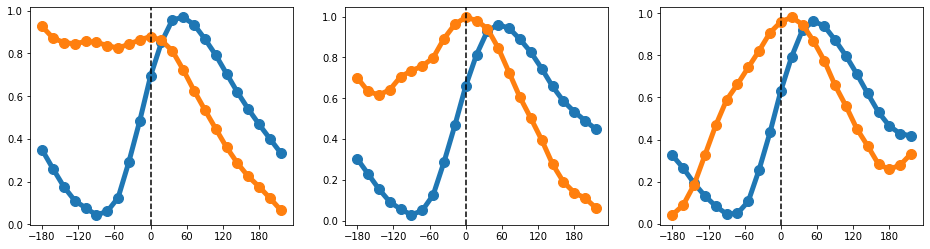

In [8]:
# From MS2 rises
def f(x):
    rises_intvol_all = findrises(intvol_f,5,3,x,100,norm=True)
    plot_triggered(intvol_f, prot_f, rises_intvol_all, norm=True)
    #plt.title(x)
imp.plot_ps(f, [0,0.12,0.25])

392


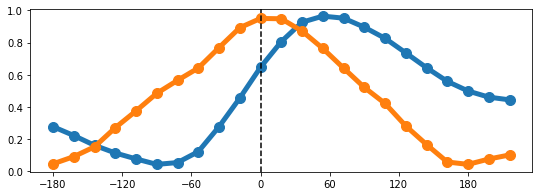

In [10]:
cut=0.22
rises_intvol_all = findrises(intvol_f,5,3,cut,100,norm=True)
fig, ax = plt.subplots(1,1, figsize=(9,3))
plt.sca(ax)
plot_triggered(intvol_f, prot_f, rises_intvol_all, norm=True)


746


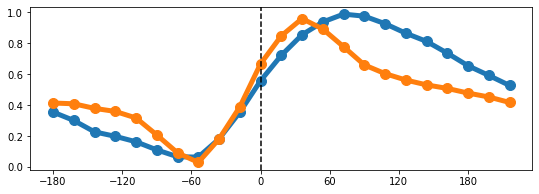

In [19]:
cut=0.1
rises_prot_all = findrises(prot_f,5,3,cut,100,norm=True)
fig, ax = plt.subplots(1,1, figsize=(9,3))
plt.sca(ax)
plot_triggered(intvol_f, prot_f, rises_prot_all, norm=True)



In [76]:
def plot_traces_base(table1, table2, windowsize=1, num_to_plot=9):
    """Compare two integrations, normalize each trace 0 to 1"""
    
    def norm(data, x):
        data_norm = (data[x] - data[x].min()) / (data[x].max() - data[x].min())
        return(data_norm)
    
    def test(x):
        data = norm(table1, x).rolling(windowsize, center=True).mean()
        data.plot(marker="o", color="blue") 
        data2 = norm(table2, x).rolling(windowsize, center=True).mean()
        data2.plot(marker="p", color="orange")
        plt.title(x)
        
    imp.plot_ps(test, range(1,num_to_plot+1))

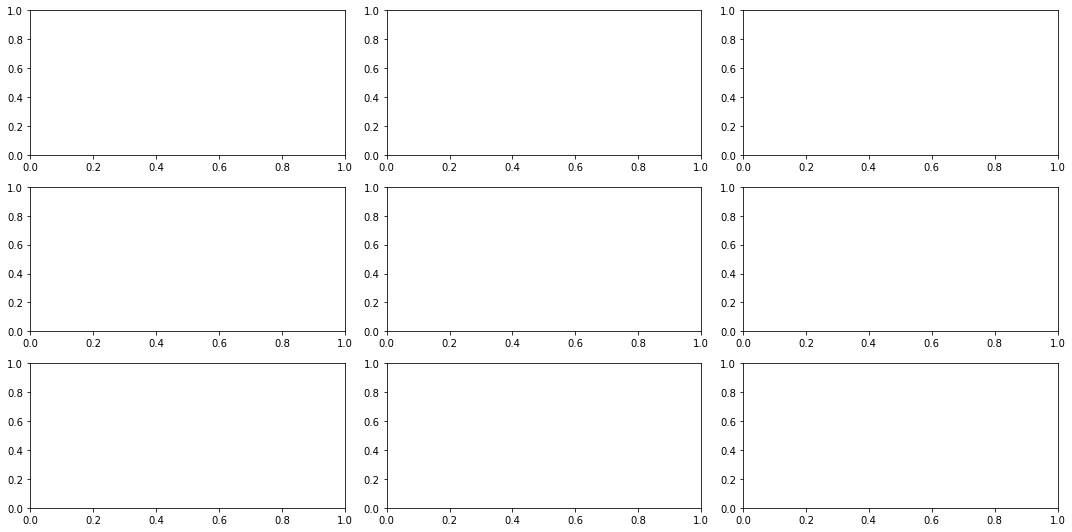

In [86]:
plt.subplots(3,3,figsize=(15,7.5));
plt.tight_layout()

In [98]:
def norm(x):
    x_norm = (x - x.min())/ (x.max() - x.min())
    return(x_norm)

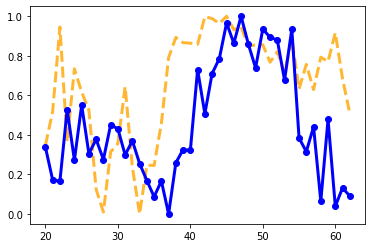

In [171]:
#102, 104, 131, 132, 133, 135, 137, 149, 150
n=150
xvals = np.arange(0, len(intvol_f[n]))
plt.plot(xvals, norm(prot_f[n]), linewidth=3, linestyle="--", alpha=0.8, color="orange");
plt.plot(xvals, norm(intvol_f[n]), linewidth=3, marker="o", color="blue");
plt.xticks(None);
#plt.figsize(5,5)


# Enrichment and radial

In [24]:
mv_sna1 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20200825-rpb1Snams2-em1-zsmv-07-09.pkl')

In [25]:
mv_eve1 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20180811-rpb1-eve-em1-zsmv-06.pkl')

In [26]:
from skimage.filters.thresholding import threshold_li, threshold_otsu

def mask_rpb1_foci(stack, mask, sigma1=3, dilation_len=10):
    """Mask Rpb1 foci within nuclei"""
    mask_foci = np.zeros_like(stack)
    for i in range(0, stack.shape[0]):
        maxp = stack[i].max(axis=0)
        im_smooth = ndi.filters.gaussian_filter(maxp, sigma=sigma1)
        # Make second mask of pol2 foci (presumed HLBs) by re-thresholding within nuclei.
        t_foci = threshold_otsu(im_smooth[mask[i,0].astype('bool')])
        mask_2d = np.where(im_smooth > t_foci, True, False)
        mask_2d = ndi.morphology.binary_dilation(mask_2d, structure=np.ones((dilation_len, dilation_len)))
        mask_3d = np.repeat([mask_2d], stack.shape[1], axis=0)
        mask_foci[i] = mask_3d
    return mask_foci.astype('bool')

from random import random
def random_spot_data(spot_data, mask, n):
    """Produce spot_data for spots in random positions within nuclei, constrained by HLB mask"""
    rand_spot_data = {}
    for spot in spot_data:
        rand_spot_data[spot] = np.ndarray((spot_data[spot].shape[0] * n, spot_data[spot].shape[1]))
        rownum=0
        arr = spot_data[spot]
        for row in arr:
            t, nuc, z = [int(x) for x in row[0:3]]
            x,y = np.where(mask[t,z] == nuc)
            numpix = len(x)
            for i in range(0, n):
                rand = int(numpix * random())
                randx, randy = x[rand], y[rand]
                newrow = row.copy()
                newrow[3:5] = [randx, randy]
                rand_spot_data[spot][rownum] = newrow
                rownum = rownum + 1
    return rand_spot_data

def project(x):
    x1 = x[:,:,2:5].sum(axis=2).sum(axis=1).sum(axis=0)
    return x1

def radial(data):
    x,y, = imp.mesh_like(data, 2)
    cenx = int(data.shape[0] / 2)
    ceny = int(data.shape[0] / 2)
    dist = np.sqrt(((x - cenx)**2) + ((y - ceny)**2))
    sums = np.zeros(int(dist.max()) + 1)
    counts = np.zeros(int(dist.max()) + 1)
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            dist_bin = int(dist[i,j])
            sums[dist_bin] = sums[dist_bin] + data[i,j]
            counts[dist_bin] = counts[dist_bin] + 1
    return sums / counts

In [27]:
mv = mv_eve1
hlb_mask = mask_rpb1_foci(mv.stack[0], mv.nucmask)
nucmask_masked = np.where(hlb_mask, 0, mv.nucmask)
rand_data = random_spot_data(mv.spot_data, nucmask_masked, 5)
true_ms2 = imp.spot_movies(mv.stack, mv.spot_data, channel=1, fill=0, len_ij=31, view=False)
true_prot = imp.spot_movies(mv.stack, mv.spot_data, channel=0, fill=0, len_ij=31, view=False)
rand_ms2 = imp.spot_movies(mv.stack, rand_data, channel=1, fill=0, len_ij=31, view=False)
rand_prot = imp.spot_movies(mv.stack, rand_data, channel=0, fill=0, len_ij=31, view=False)
tm = project(true_ms2)
rm = project(rand_ms2)
tp = project(true_prot)
rp = project(rand_prot)

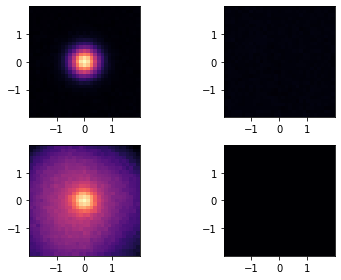

In [40]:
fig, ax = plt.subplots(2,2)


img = ax[0][0].imshow(tm,cmap="magma", vmax=tm.max(), vmin=tm.min())
img.set_extent([-2,2, -2,2])
ax[0][0].set_xticks([-1,0,1])
ax[0][0].set_yticks([-1,0,1])
img = ax[0][1].imshow(rm,cmap="magma", vmax=tm.max(), vmin=tm.min())
img.set_extent([-2,2, -2,2])
ax[0][1].set_xticks([-1,0,1])
ax[0][1].set_yticks([-1,0,1])
img = ax[1][0].imshow(tp,cmap="magma", vmax=tp.max(), vmin=tp.min())
img.set_extent([-2,2, -2,2])
ax[1][0].set_xticks([-1,0,1])
ax[1][0].set_yticks([-1,0,1])
img = ax[1][1].imshow(rp,cmap="magma", vmax=tp.max(), vmin=tp.min())
ax[1][1].set_xticks([-1,0,1])
ax[1][1].set_yticks([-1,0,1])
img.set_extent([-2,2, -2,2])
fig.tight_layout()

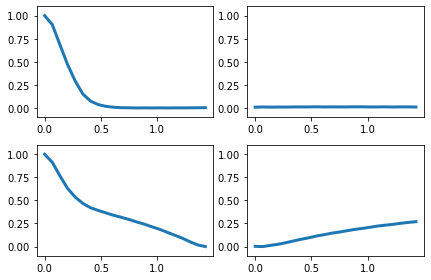

In [226]:
fig, ax = plt.subplots(2,2)
r_tm = radial(tm)
r_rm = radial(rm)
r_tp = radial(tp)
r_rp = radial(rp)

def norm(a,b):
    min_ = min([b.min(), a.min()])
    return (a - min_) / (b.max() - min_)
xvals = np.arange(0,22) * 0.068
ax[0][0].plot(xvals, norm(r_tm, r_tm), linewidth=3)
ax[0][0].set_ylim(-0.1,1.1)
ax[0][1].plot(xvals, norm(r_rm, r_tm), linewidth=3)
ax[0][1].set_ylim(-0.1,1.1)
ax[1][0].plot(xvals, norm(r_tp, r_tp), linewidth=3)
ax[1][0].set_ylim(-0.1,1.1)
#ax[1][1].plot(np.arange(0, len(r_rp)), norm(r_rp, r_tp)
ax[1][1].plot(xvals, norm(r_rp, r_tp), linewidth=3)
ax[1][1].set_ylim(-0.1,1.1)

fig.tight_layout()

In [209]:
len(r_tm)

22